#import libraries

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [6]:
79*32

2528

In [7]:
image_size =300
batch_size = 32
dataset_path = "/content/drive/MyDrive/lemon_dataset"

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        seed = 123,
        shuffle = True,
        batch_size = batch_size,
        image_size = (image_size,image_size),
)

Found 2528 files belonging to 3 classes.


In [9]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
dataset.class_names

['bad_quality', 'empty_background', 'good_quality']

In [11]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 300, 300, 3)
[0 0 2 2 2 1 0 2 1 0 2 2 2 0 2 2 2 2 0 2 0 1 2 2 2 1 2 2 2 2 0 2]


## total 79 batches


In [12]:
len(dataset)

79

In [13]:
class_names = dataset.class_names

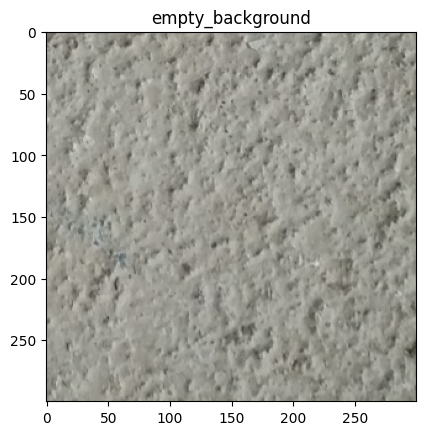

In [14]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])

In [15]:
print(dataset.class_names)  # shows the order of labels


['bad_quality', 'empty_background', 'good_quality']


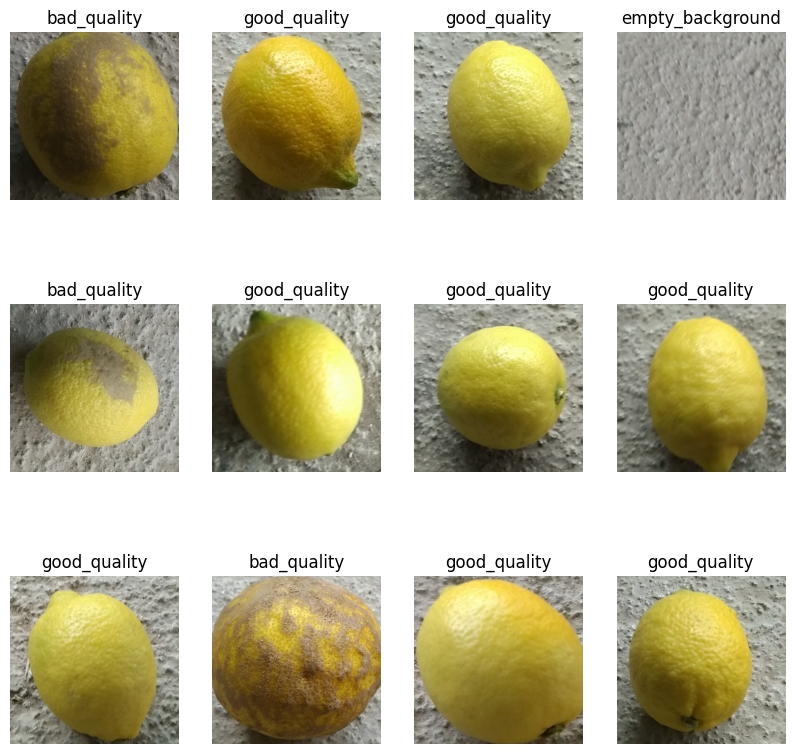

In [16]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

# spliting the  dataset for train , test, validation

In [17]:
len(dataset)

79

In [18]:
#training
79*.8

63.2

In [19]:
# 10% validation, 10% test , 80 % training

In [20]:
def split_dataset(dataset, train_split=0.8, test_split= 0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
  assert(train_split + test_split + val_split) == 1     # checks datasplits size

  dataset_size =len(dataset)

  if shuffle:
    dataset = dataset.shuffle(shuffle_size,seed=12)

    train_size = int(dataset_size*train_split)
    val_size = int(dataset_size*val_split)

    train_set = dataset.take(train_size)
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)

    return train_set,test_set,val_set

In [21]:
train_set, test_set, val_set = split_dataset(dataset)

In [22]:
def check_size(training_set, testing_set, validation_set):
  print(f'training_set : {len(training_set)}')
  print(f'testing_set : {len(testing_set)}')
  print(f'validation_set : {len(validation_set)}')

In [23]:
check_size(train_set, test_set, val_set)

training_set : 63
testing_set : 9
validation_set : 7


# cache, shuffle, prefetch the Dataset

In [24]:
# cache for image stored in memory so that we don't have to load dataset from dir .
# improves performance

In [25]:
# prefetch
# While the model is training on one batch of data,
# the  mechanism loads and preprocesses the next batch in the background.

# Asynchronous Execution: It ensures that the data is ready in memory before the training step needs it,
# reducing idle time and improving efficiency

# Buffering: A buffer is used to store preprocessed batches ,
# so the GPU (or other processing unit) can keep working without waiting


In [26]:
train_dataset = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Building


In [27]:
# model image needs to be resized so that no other images of diff size can be handled while testing .
# images need to be scaled that is images need to normalized for improved performance

In [28]:
# Normalization: Rescaling the pixel values improves model training by eliminating large numeric values, which can destabilize gradient calculations.
# It's also crucial when the model expects inputs in a specific range
#  (e.g.,  for models pretrained on datasets like ImageNet).

In [29]:
resize_rescale_img = tf.keras.Sequential([
    tf.keras.layers.Resizing(image_size,image_size),
    tf.keras.layers.Rescaling(1.0/299),
])

## data augmentation

In [30]:
# improves generalization , reduces overfitting prevents memorization  , creates synthetic data
# Saves resources by generating additional data without requiring new labeled data.

In [31]:
# import tensorflow as tf
# from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# # Create a data augmentation layer
# data_augmentation = tf.keras.Sequential([
#     RandomFlip("horizontal"),  # Randomly flip images horizontally
#     RandomRotation(0.1),       # Rotate images by up to 10%
#     RandomZoom(0.1)            # Zoom images by up to 10%
# ])

# # Apply augmentation to an example image
# example_image = tf.random.uniform(shape=(1, 224, 224, 3))  # Example image tensor
# augmented_image = data_augmentation(example_image)

In [32]:
Data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),                    # Rotate images by up to 20%

])

### applying data augmentation to training_data

In [33]:
train_dataset = train_dataset.map(
    lambda x, y: (Data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
n_classes = 3

## model architecture

In [35]:
channel = 3
input_shape = (batch_size, image_size, image_size, channel)

model =  models.Sequential([
    resize_rescale_img,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(image_size,image_size,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes ,activation='softmax'),

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.build(input_shape = input_shape)

In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 300, 300, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 298, 298, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 149, 149, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 147, 147, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 73, 73, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 71, 71, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 35, 35, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 33, 33, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 16, 16, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 14, 14, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 7, 7, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 5, 5, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## compiling the model

In [38]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [39]:
model_history = model.fit(
    train_dataset,
    batch_size = batch_size,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 30,
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.5068 - loss: 0.8560 - val_accuracy: 0.8214 - val_loss: 0.3478
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.8123 - loss: 0.3949 - val_accuracy: 0.8795 - val_loss: 0.2429
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.8764 - loss: 0.2847 - val_accuracy: 0.9286 - val_loss: 0.1556
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9248 - loss: 0.1869 - val_accuracy: 0.9196 - val_loss: 0.2004
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.9261 - loss: 0.1914 - val_accuracy: 0.9643 - val_loss: 0.0693
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.9339 - loss: 0.1789 - val_accuracy: 0.9598 - val_loss: 0.0936
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.9519 - loss: 0.1453 - val_accuracy: 0.9777 - val_loss: 0.0651
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.9603 - loss: 0.1131 - val_accuracy: 0.9598 - v

In [40]:
scores = model.evaluate(test_dataset)

9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9885 - loss: 0.0210


In [42]:
scores

[0.035473067313432693, 0.9791666865348816]

In [45]:
model_history

In [46]:
model_history.params

{'verbose': 1, 'epochs': 30, 'steps': 63}

In [47]:
model_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [48]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']